### Zadanie: porównanie metod klasteringu

Zajmiemy zbiorem danych z telefonów Samsung, dotyczących aktywności fizycznej.

Dane są zebrane w pliku Samsung_HAR.zip. Należy je rozpakować i przeanalizować.

Obróbka danych wejściowych:

Czy potrzeba wszystkich cech?

Czy potrzebna jest jakaś obróbka?

Czy wiemy, jak obrobić?

Czy wiemy, co jaka cecha znaczy?

Czy potrzebujemy aż dwóch plików?

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego?

Do zrobienia:

Użyj poznanych metod klasteringu, aby podzielić dany zbiór (pamiętaj o skalowaniu itp.).

Zwizualizuj podział przez każdy algorytm (możesz użyć metod z notatników).

Z jakim typem czynności algorytmy poradziły sobie super, z jakim nie najlepiej. Typy czynności (dane zawarte w plikach *labels):

1 – marsz

2 – wchodzenie w górę po schodach

3 – schodzenie w dół ze schodów

4 – siedzenie

5 – stanie

6 – leżenie

Dobierz prawidłową ilość klastrów w przypadku metody KMeans.

Na danym zbiorze dokonaj preprocessingu, używając metod klasteringu. Następnie wyszkol dwa wybrane przez siebie klasyfikatory typu Supervised Learning i spróbuj uzyskać jak najlepszy wynik, używając wszystkich znanych sobie "wspomagaczy".

W przypadku użycia train_test_split albo KFold/StratifiedKFold, możemy połączyć zbiory, gdyż i tak wydzielamy zbiór walidacyjny.

Chyba że chcemy mieć dodatkowy zbiór testowy do przetestowania modeli po wyszkoleniu. Chcemy?

Ideą klasteringu jest podział na podgrupy, czyli tutaj oczekujemy, że nasze algorytmy podzielą zbiór na 6 wspomnianych klastrów: marsz, wchodzenie/schodzenie po schodach, siedzenie, stanie, leżenie. Zbadaj, jak są porozrzucane w różnych klastrach. Im bardziej są rozrzucone, tym algorytm gorzej sobie z nimi radzi. Ideałem jest: jeden klaster, jedna czynność.

Na koniec pytanie, na które należy również odpowiedzieć, a które pojawia się zawsze podczas rozmów kwalifikacyjnych:

czym różni się KMeans, K-fold i K Nearest Neighbors (o tym ostatnim trzeba doczytać).
Rozwiązanie prześlij Mentorowi.

### Obróbka danych wejściowych:

Czy potrzeba wszystkich cech? - Nie, ponieważ mamy mieć dwa wymiary, więc tylko dwie echy będziemy analizować.

Czy potrzebna jest jakaś obróbka? - Tak, potrzebna jest obróbka danych.

Czy wiemy, jak obrobić? - Tak, muszimy z pliku txt zorbić DF i wybrać dwie cechy, bo mamy dwuwymiarowe wykresy. 

Czy wiemy, co jaka cecha znaczy? - Nie wiemy, cachy nie mają nagłówków, więc wybieramy dwie cechy "na chybił trafił".

Czy potrzebujemy aż dwóch plików? - Tak, potrzebujemy dwóch plików train i test, które połączymy, żeby mieć więcej danych.

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego? - Podział plików na dane testowe i treningowe nie jest potrzebny, ponieważ w Unsupervised Learning nie ma nauczyciela, natomiast potrzebujemy go do porównania dla Supervised Learning


In [69]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

#crossvalidation
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# wrapper
from sklearn.model_selection import cross_val_score, cross_val_predict

In [63]:
X_train = pd.read_csv('samsung_train.txt', header=None, delim_whitespace=True)
X_test = pd.read_csv('samsung_test.txt', header=None, delim_whitespace=True)
X = pd.concat([X_train, X_test], ignore_index=True)
X = X[[100,300]]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   100     10299 non-null  float64
 1   300     10299 non-null  float64
dtypes: float64(2)
memory usage: 161.0 KB


In [64]:
y_train = pd.read_csv('samsung_train_labels.txt', header=None, delim_whitespace=True)
y_test = pd.read_csv('samsung_test_labels.txt', header=None, delim_whitespace=True)
y = pd.concat([y_train, y_test], ignore_index=True)
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       10299 non-null  int64
dtypes: int64(1)
memory usage: 80.6 KB


<AxesSubplot: xlabel='x1', ylabel='x2'>

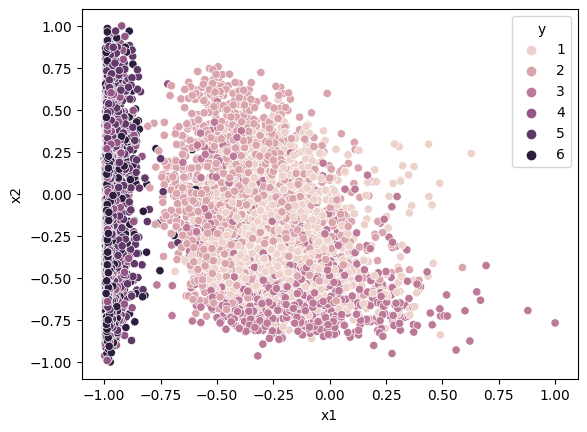

In [65]:
wykres = pd.concat([X, y],axis=1,ignore_index=False)
wykres.columns = ['x1', 'x2', 'y']
sns.scatterplot(data=wykres, x="x1", y="x2", hue='y')

In [66]:
X = X.to_numpy()
y = y[0].to_numpy()
display(X)
display(y)


array([[-0.98602487,  0.24676868],
       [-0.97943511,  0.05667537],
       [-0.98014451, -0.04493677],
       ...,
       [-0.60215305, -0.31966712],
       [-0.60259808, -0.40453056],
       [-0.56451491, -0.5106928 ]])

array([5, 5, 5, ..., 2, 2, 2], dtype=int64)

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=42, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], 
                                                                X_test.shape[0]))

Treningowe obserwacje: 8239
Testowe obserwacje: 2060


In [70]:
sgdc_clf = SGDClassifier(random_state=1)
svm_clf = SVC()
log_reg_clf = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)

sgdc_clf.fit(X_train, y_train)
sgdc_score = sgdc_clf.score(X_test, y_test)
print("Pojedynczy wynik dla SGDC: ", sgdc_score)

svm_clf.fit(X_train, y_train)
svm_score = svm_clf.score(X_test, y_test)
print("Pojedynczy wynik dla SVM: ", svm_score)

log_reg_clf.fit(X_train, y_train)
log_reg_score = log_reg_clf.score(X_test, y_test)
print("Pojedynczy wynik dla LogisticRegression: ", log_reg_score)

Pojedynczy wynik dla SGDC:  0.3859223300970874
Pojedynczy wynik dla SVM:  0.49029126213592233
Pojedynczy wynik dla LogisticRegression:  0.46310679611650485


### Crossvalidation

In [71]:
scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

for fold_nr, (train_idx, test_idx) in enumerate(kf.split(X)):
  X_train = X[train_idx]
  X_test =X[test_idx]

  y_train = y[train_idx]
  y_test = y[test_idx]

  # skalowanie danych wejściowych, aby model lepiej działał
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  clf = SGDClassifier(random_state=1).fit(X_train, y_train)

  models.append(clf)
  scores.append(clf.score(X_test, y_test))


print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

wyniki poszczególnych foldów:  [0.39029126213592236, 0.36067961165048545, 0.31359223300970873, 0.3490291262135922, 0.4497328800388538]
średni wynik wszystkich foldów:  0.3726650226097125


In [72]:
# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

wynik kroswalidacji:  [0.42087379 0.41359223 0.43398058 0.50873786 0.43807674]
średni wynik wszystkich foldów:  0.443052240459833


##### Crossvalidacja Kfold nie poprawiła wyniku.

In [73]:
# wcześniejszy przykład z użyciem stratifiedKFold
from sklearn.model_selection import StratifiedKFold

# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

# iteracja przez poszczególne foldy
# dodatkowy parametr y w metodzie split
for fold_nr, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X[train_idx]
    X_test =X[test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]

    # skalowanie danych wejściowych, aby model lepiej działał
    # skalowanie danych wewnątrz poszczeŋólnych iteracji
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # stworzenie klasyfikatora dla poszczególnej iteracji
    # wytrenowanie klasyfikatora na danych treningowych
    clf = SGDClassifier(random_state=1).fit(X_train, y_train)
    
    # dodawanie klasyfikatora do tablicy klasyfikatorów
    models.append(clf)
    # dodawanie wyniku dla danych testowych do tablicy
    scores.append(clf.score(X_test, y_test))

print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

wyniki poszczególnych foldów:  [0.41941747572815535, 0.3907766990291262, 0.4320388349514563, 0.42961165048543687, 0.35405536668285575]
średni wynik wszystkich foldów:  0.4051800053754061


##### Crossvalidacja z użyciem stratyfikacji również nie poprawiła wyniku.

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

#Przykład podziału za pomocą stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=3, stratify=y)
# summarize
train_1, train_2, train_3, train_4, train_5, train_6 = len(y_train[y_train==1]), len(y_train[y_train==2]), len(y_train[y_train==3]), len(y_train[y_train==4]), len(y_train[y_train==5]), len(y_train[y_train==6])
test_1, test_2, test_3, test_4, test_5, test_6 = len(y_test[y_test==1]), len(y_test[y_test==2]), len(y_test[y_test==3]), len(y_test[y_test==4]), len(y_test[y_test==5]), len(y_test[y_test==6])

print('>Train: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d, Test: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d' % (train_1, train_2, train_3, train_4, train_5, train_6, test_1, test_2, test_3, test_4, test_5, test_6))

>Train: 1=1378, 2=1235, 3=1125, 4=1421,5=1525, 6=1555, Test: 1=344, 2=309, 3=281, 4=356,5=381, 6=389


### Clustering

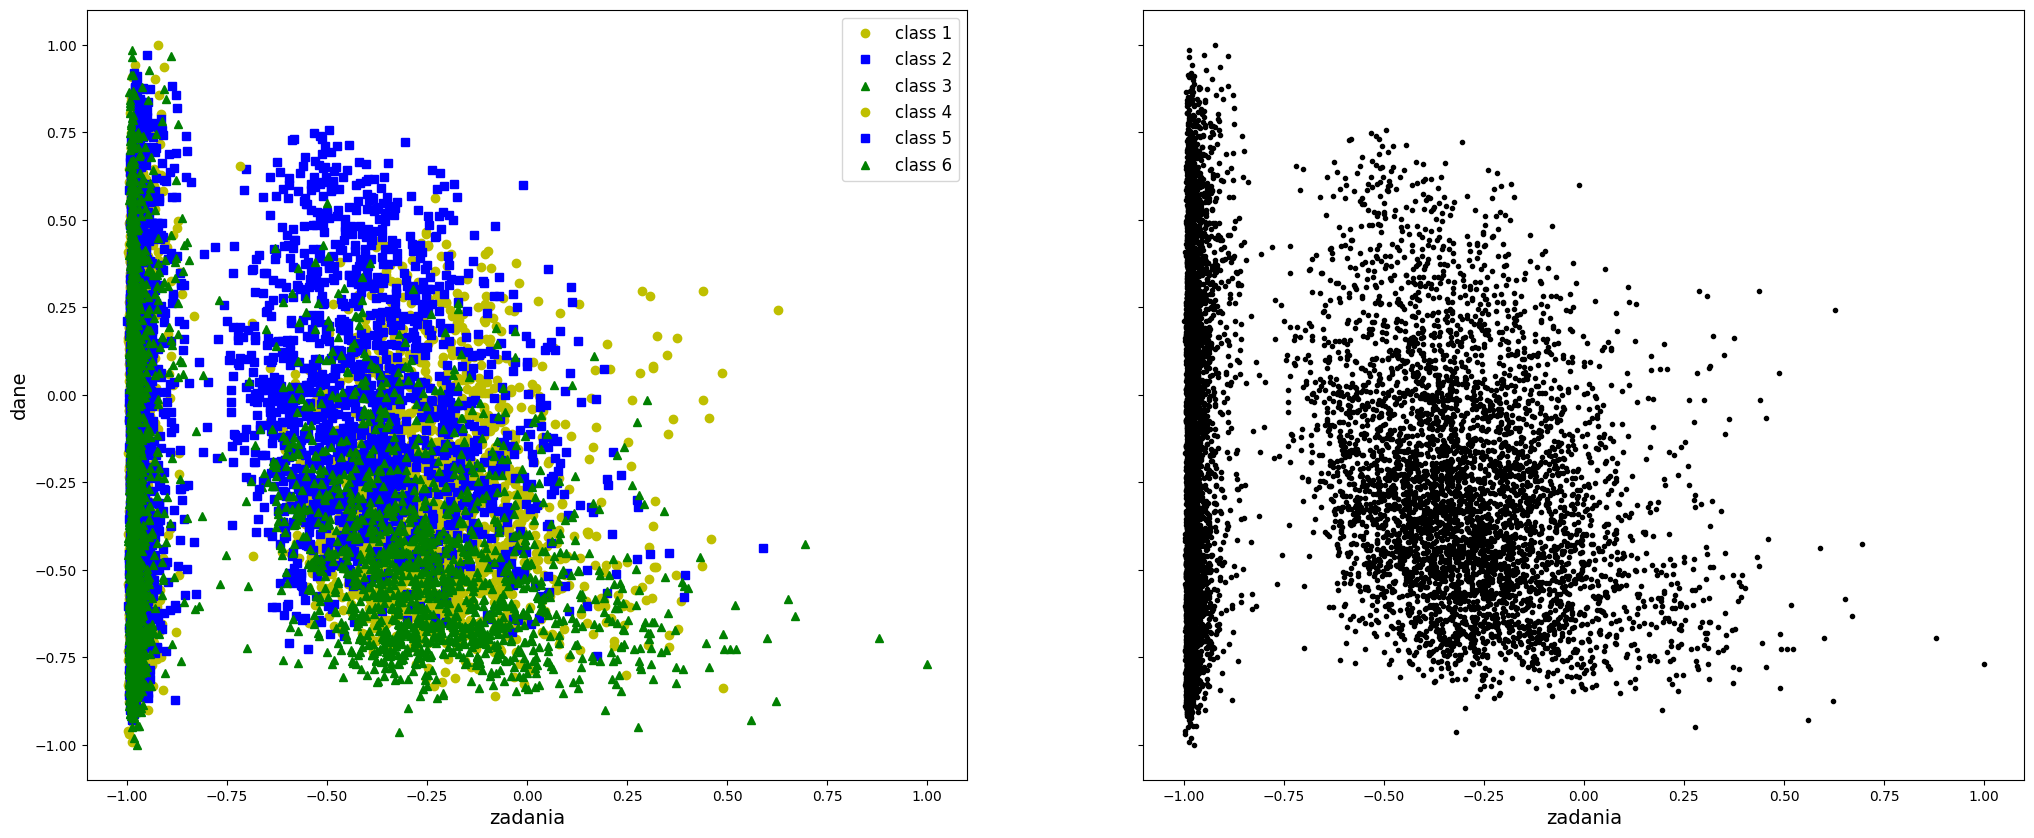

In [78]:
# przykład podziału dancyh w przypadku Supervised Learning oraz Clusteringu

plt.figure(figsize=(25, 10))

plt.subplot(121)
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="class 1")
plt.plot(X[y==2, 0], X[y==2, 1], "bs", label="class 2")
plt.plot(X[y==3, 0], X[y==3, 1], "g^", label="class 3")
plt.plot(X[y==4, 0], X[y==4, 1], "yo", label="class 4")
plt.plot(X[y==5, 0], X[y==5, 1], "bs", label="class 5")
plt.plot(X[y==6, 0], X[y==6, 1], "g^", label="class 6")
plt.xlabel("zadania", fontsize=14)
plt.ylabel("dane", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c="k", marker=".")
plt.xlabel("zadania", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

### Podstawowe metody (KMeans)

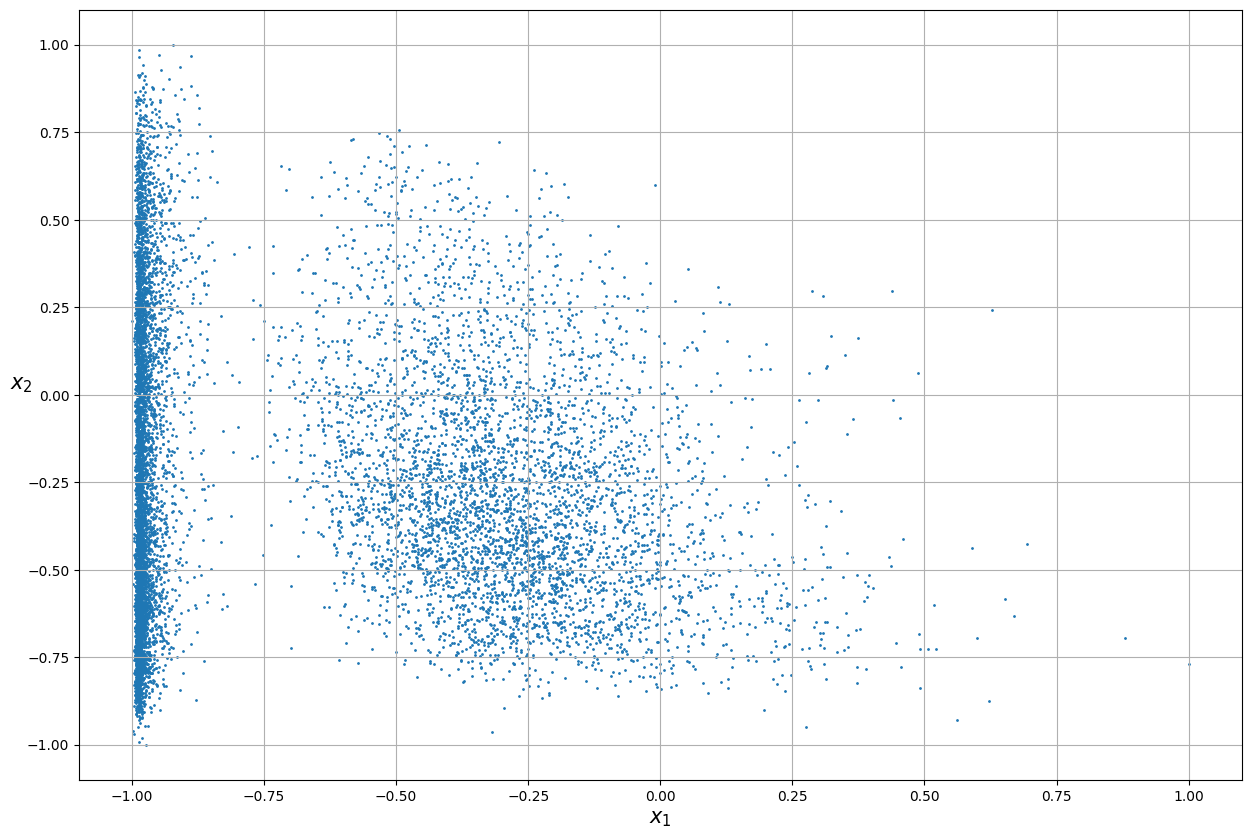

In [81]:
def plot_clusters(X, y=None):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)
    plt.grid()

plot_clusters(X)

##### # Dobieramy ilość klastrów

In [99]:
# import odpowiedniej biblioteki
from sklearn.cluster import KMeans

#1 Tworzymy 19 algorytmów z k od 1 do 19
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=42).fit(X)
    for k in range(2, 20) # zaczynamy od wartości n_clusters wynoszącej 2, gdyż nie ma sensu dzielenia zbioru dla 1 klastra
]

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

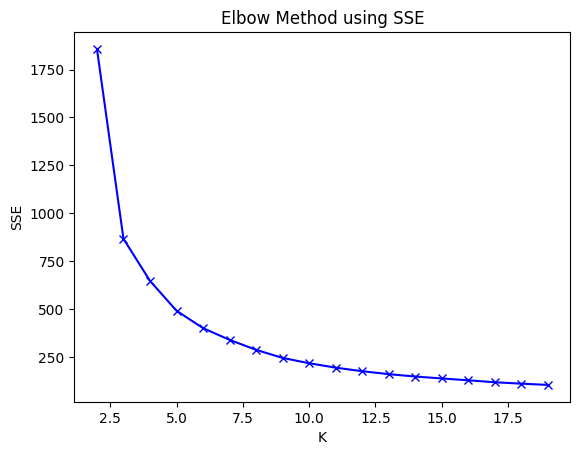

In [100]:
import matplotlib.pyplot as plt
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(2, 20), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method using SSE')
plt.show()

In [101]:
#2. Używamy tzw silhouette_score

from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k]

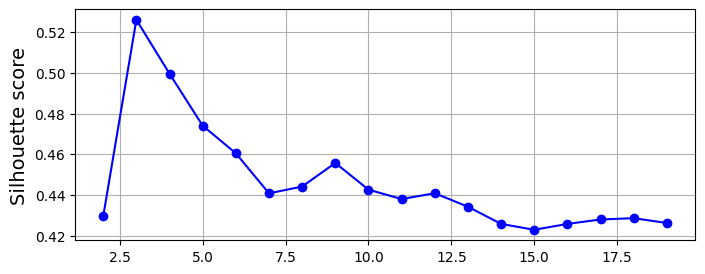

In [102]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

---
KMeans i Silhouette pokazuje, że najlepiej, aby były 3 klastry, a my potrzebujemy 6, z tym, że my wzięliśmy do analizy tylko dwie losowe cechy.

In [ ]:
# Wykresy dla 3 i 6 klastrów:


In [104]:
clf3 = KMeans(n_clusters=3)

# możemy uzyć metod fit(), predict() 
clf3.fit(X)
y_pred = clf3.predict(X)

#albo metody fit/predict, która łączy dwie powyższe

y_pred = clf3.fit_predict(X)
print(y_pred)

[1 1 1 ... 0 0 0]


c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [105]:
clf3.cluster_centers_

array([[-0.24573943, -0.35078238],
       [-0.86296982,  0.27374232],
       [-0.9728824 , -0.53539883]])

In [106]:
clf6 = KMeans(n_clusters=6)

# możemy uzyć metod fit(), predict() 
clf6.fit(X)
y_pred = clf6.predict(X)

#albo metody fit/predict, która łączy dwie powyższe

y_pred = clf6.fit_predict(X)
print(y_pred)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 1 1 ... 5 5 5]


In [107]:
clf6.cluster_centers_

array([[-0.31296453,  0.1333388 ],
       [-0.96123758, -0.09494132],
       [-0.09100552, -0.56498802],
       [-0.94451489,  0.44907224],
       [-0.97717206, -0.622358  ],
       [-0.37512711, -0.33021588]])

In [108]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

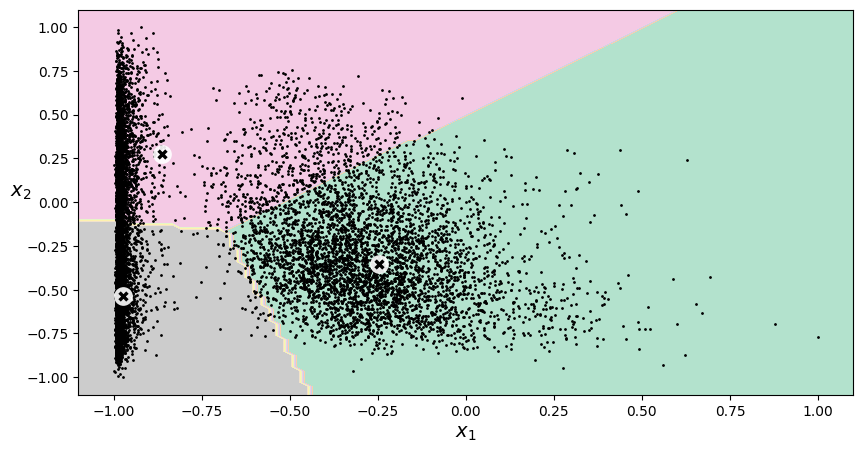

In [109]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf3, X)
plt.show()

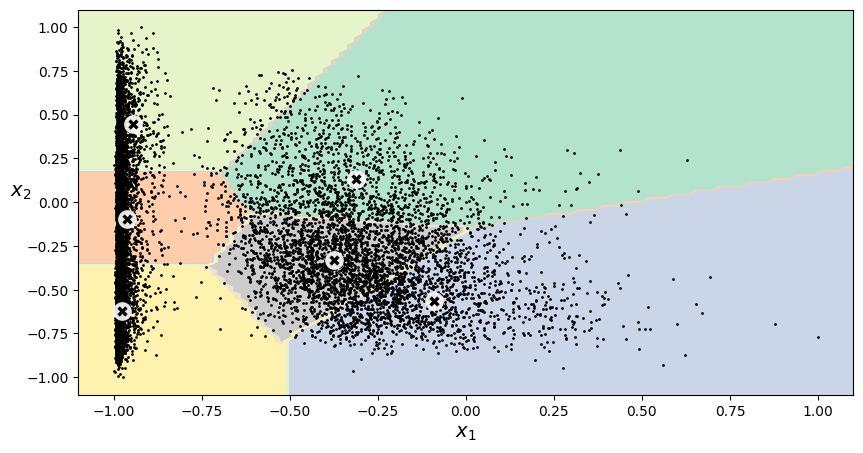

In [110]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf6, X)
plt.show()

### # KMeans vs MiniBatchKMeans

In [111]:
# import odpowiedniej biblioteki
from sklearn.cluster import KMeans, MiniBatchKMeans

%timeit

# metoda MiniBatchKMeans
MBKMeans_clf = MiniBatchKMeans(n_clusters=6, max_iter=10, random_state=1)
%timeit MBKMeans_clf.fit(X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `

95.8 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
from sklearn.cluster import KMeans

%timeit

# metoda KMeans
KMeans_clf = KMeans(n_clusters=6, max_iter=10, random_state=1)
%timeit KMeans_clf.fit(X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

93.8 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


---
KMeans był szybszy od MiniBatchKMeans w naszym przypadku.

In [113]:
# KMeans jako preprocessing danych

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Użyj prostego klasyfikatora LogisticRegression, aby przewidzieć jaką cyfrę przedstawia 
# obrazek i wypisz uzyskany wynik (użyj multi_class="ovr")
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)
print("Bez KMeans :", log_reg.score(X_test, y_test))

# Utwórz pipeline składający się z: 
# - KMeansClustering z ilością klastrów znacznie większą od ilości klas w zbiorze 
# (w praktyce o wiele lepiej działa stworzenie większej ilości klastrów niż chcemy 
# przewidzieć klas) 
# - oraz LogisticRegression
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=40, random_state=2)),
    ("log_reg", LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)),
])

# Naucz taki pipeline i wypisz wynik
pipeline.fit(X_train, y_train)
print("Z KMeans :", pipeline.score(X_test, y_test))

Bez KMeans : 0.45507527926177754


c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Z KMeans : 0.4788732394366197


---
Widać, że akurat w tym przypadku użycie preprocessingu w postaci KMeans nie powoduje poprawienia wyniku.

### DBSCAN

In [115]:
from sklearn.cluster import DBSCAN

# tworzymy pierwszy klasyfikator DBSCAN z eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=6)
dbscan.fit(X)

# drugi DBSCAN z eps = 0.2 (większy epsilon, większa przestrzeń wokół)
dbscan_2 = DBSCAN(eps=0.2, min_samples=6)
dbscan_2.fit(X)

DBSCAN(eps=0.2, min_samples=6)

In [116]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], 
                marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), 
                fontsize=14)

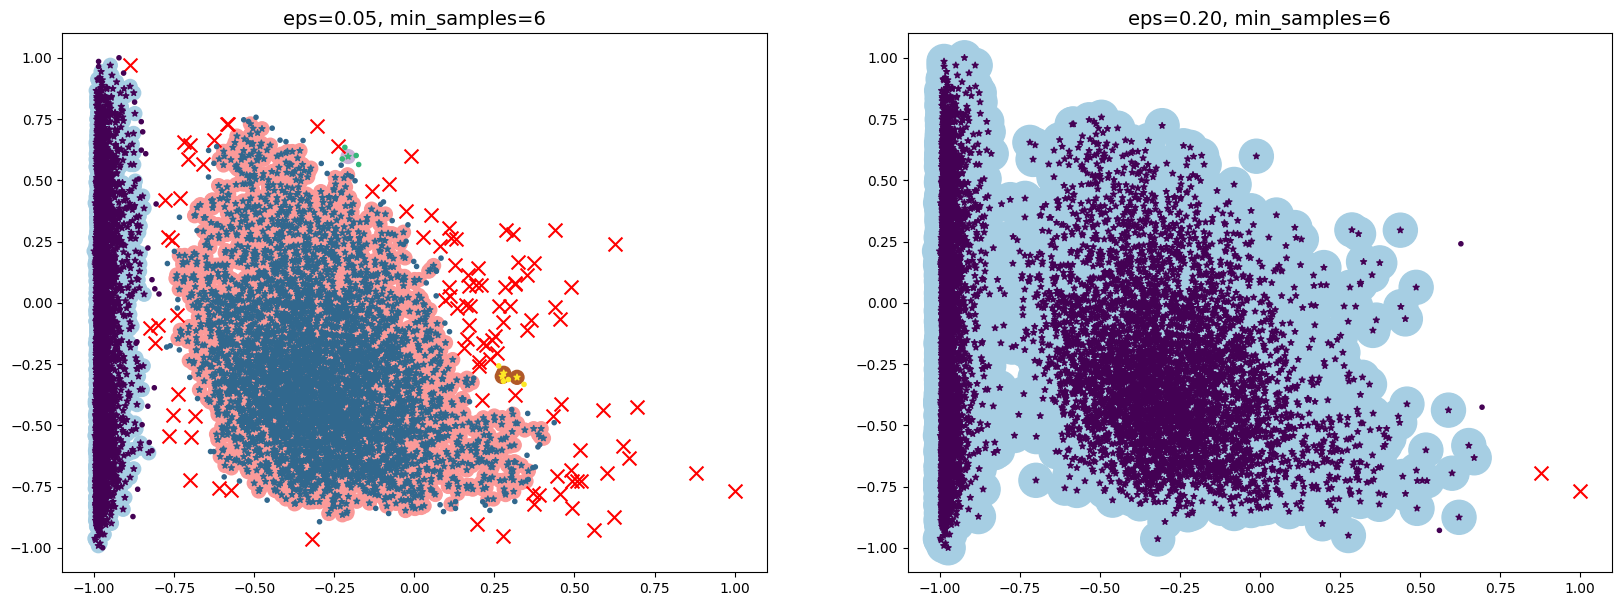

In [117]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)
plt.subplot(122)
plot_dbscan(dbscan_2, X, size=600)
plt.show()

### Gaussian Mixture Models (GNN)

In [122]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=6, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=6, n_init=10, random_state=42)

In [123]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# metoda zaporzyczona z przykładów sklearn oraz lekko zmodyfikowana 
def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


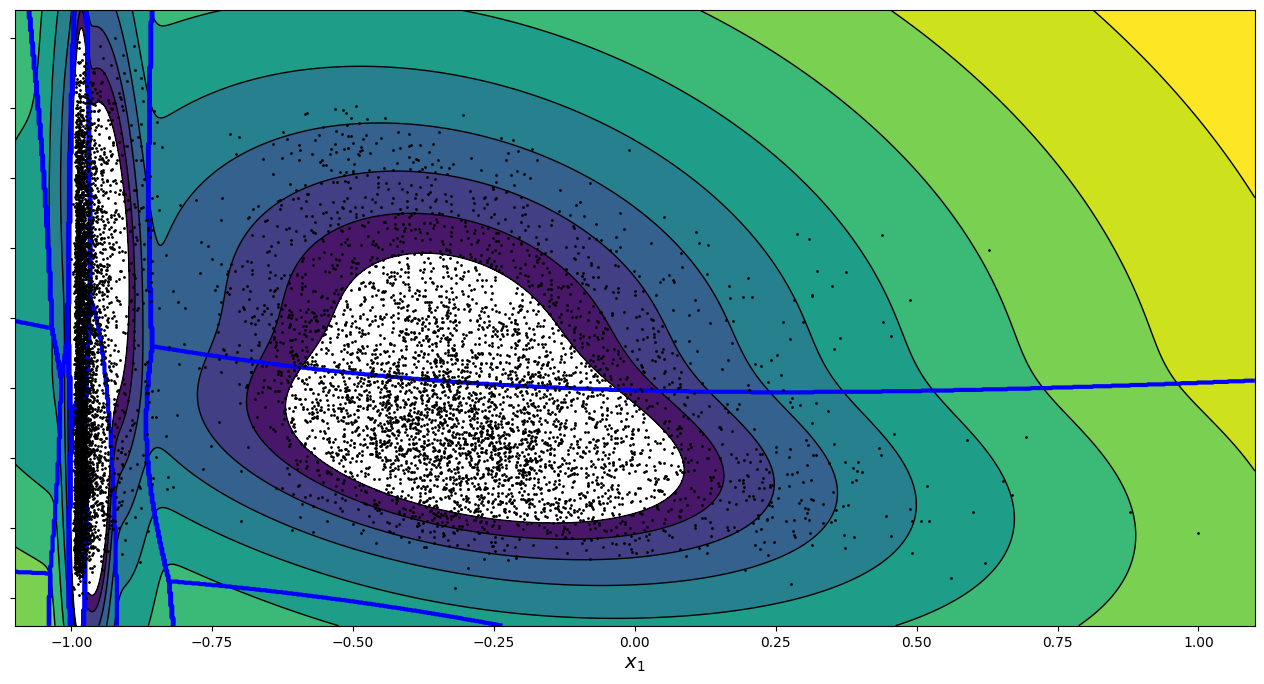

In [124]:
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

In [125]:
gm.converged_

True

In [ ]:
# algorytm skończył działanie

In [126]:
gm.n_iter_

17

In [127]:
# alborytm potrzebował 17 iteracji

In [129]:
# Zobaczmy jak wygląda wykres przy zmianach hiperparametru covariance_type:

C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


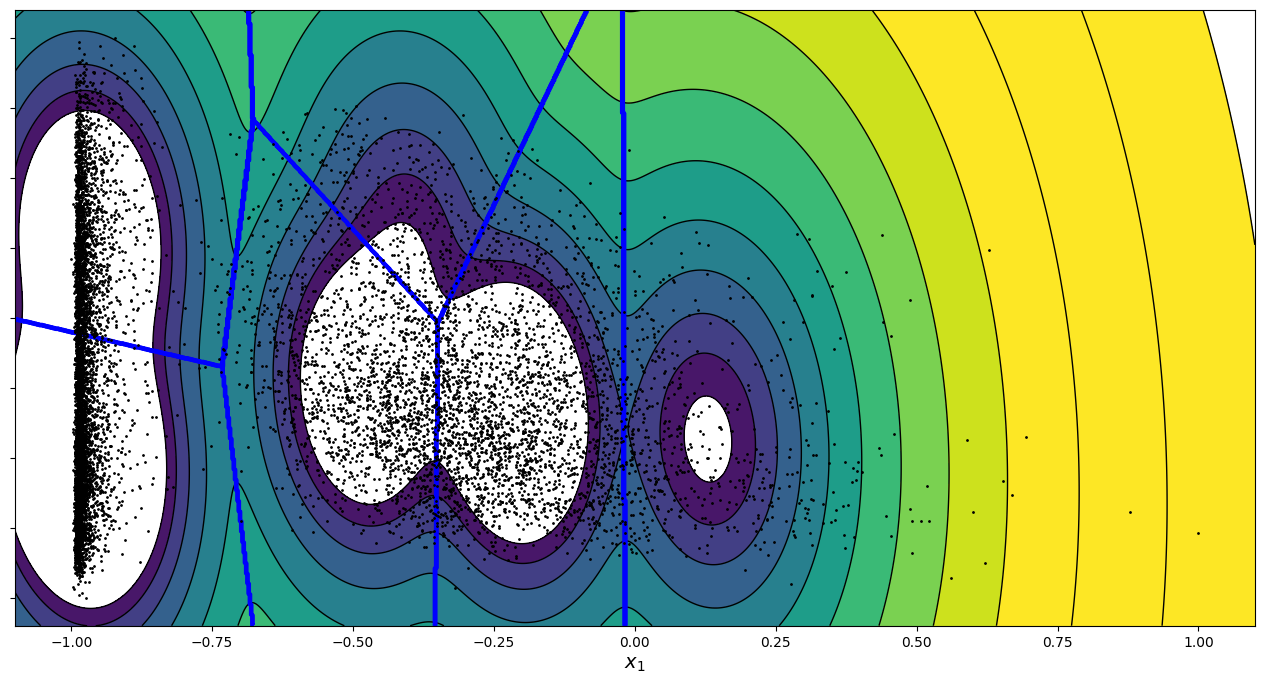

In [132]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42, covariance_type="tied")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


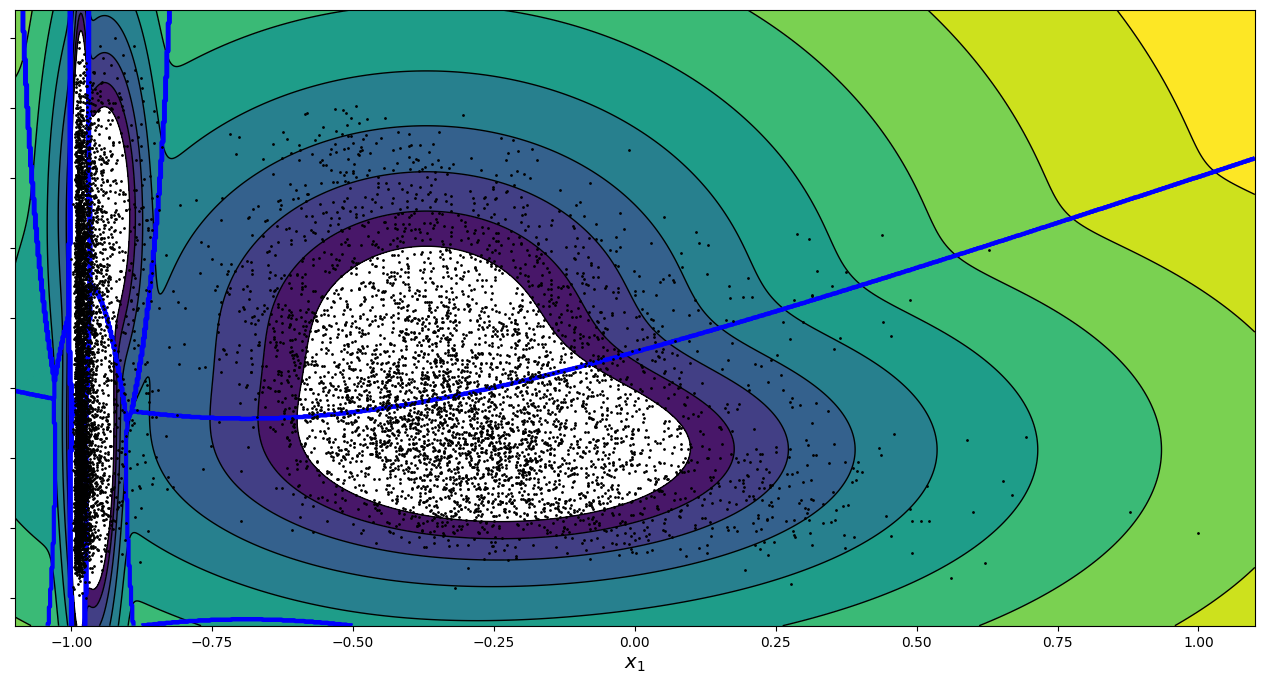

In [133]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42, covariance_type="diag")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


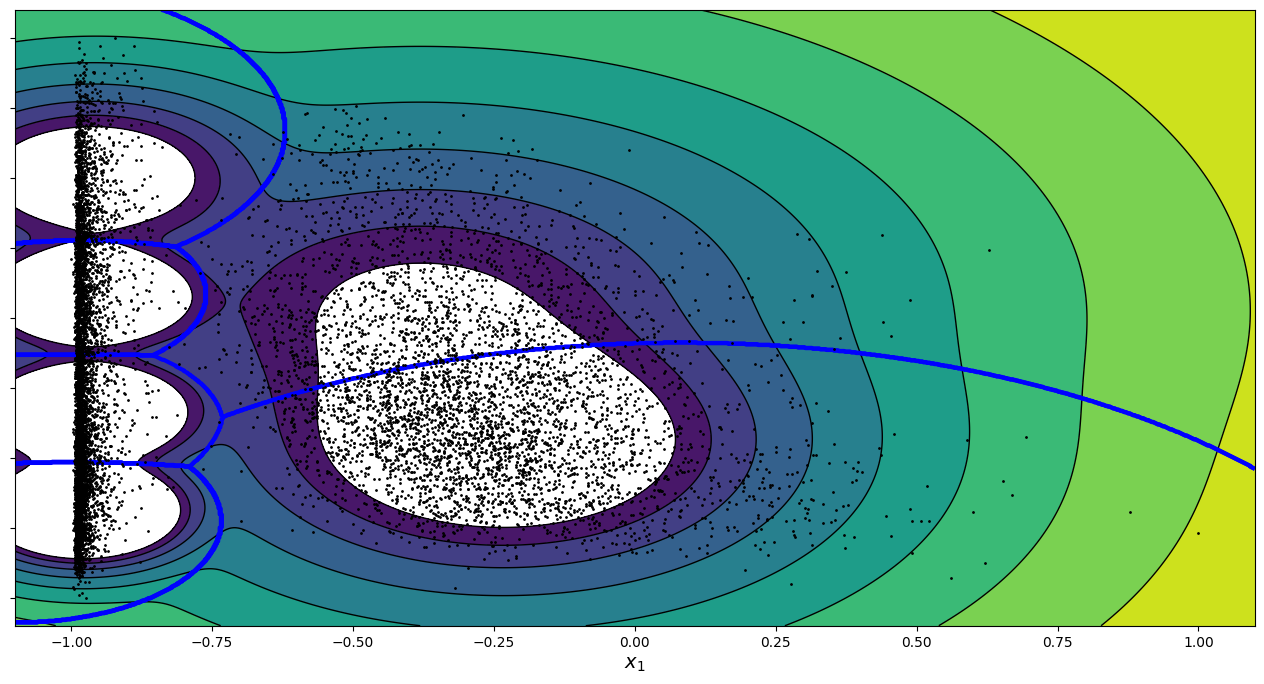

In [134]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42, covariance_type="spherical")
gm.fit(X)
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

### GMM jako wykrywacz anomalii

C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\magda\AppData\Local\Temp\ipykernel_9352\3503094484.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


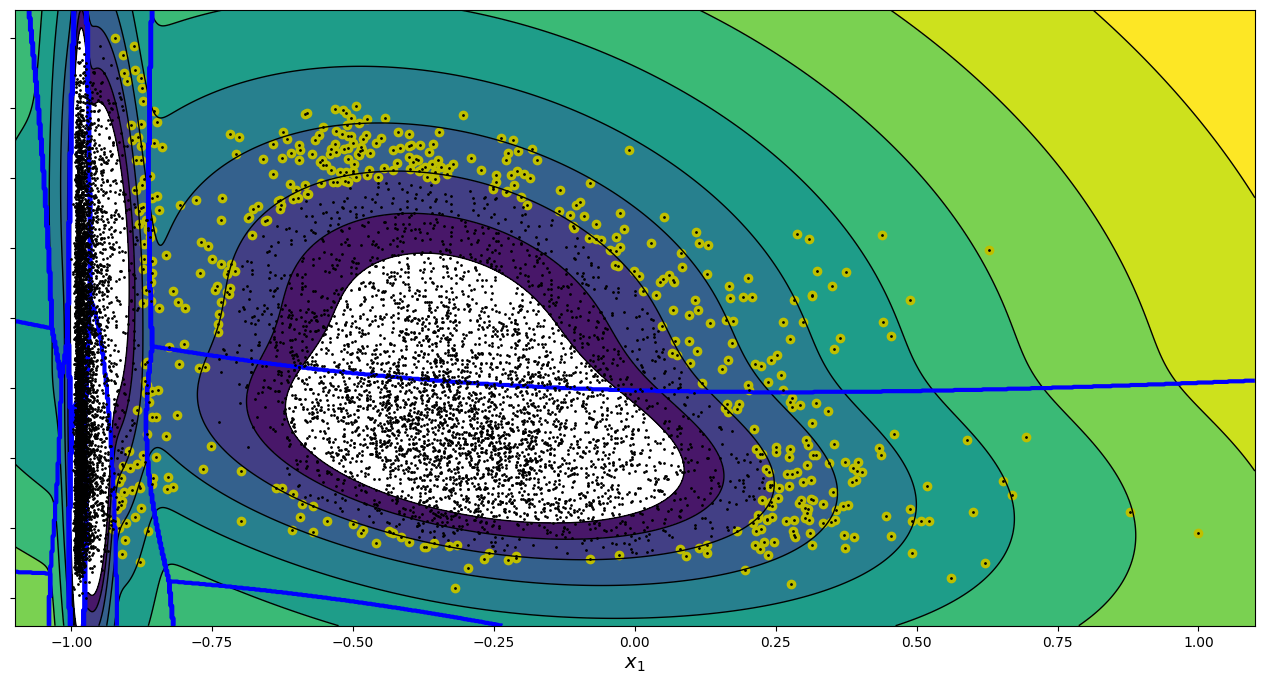

In [135]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42)
gm.fit(X)

plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)

# odsiewanie anomalii
# Pobieramy wartości dla naszego zbioru, które
# mówią nam, jak bardzo element należy do klastrów
density = gm.score_samples(X)

# Tworzymy wartość graniczną, czyli threshold. 
# Wartości, które mają wyniki z poprzedniej linii mniejsze od naszego threshold, 
# są anomaliami, więc zostają odsiane
# W naszym przypadku chcemy odsiać 5% najgorszych wartości
threshold = np.percentile(density, 5)

# Odsiewamy te wartości poprzez proste porównanie
anomalie = X[density < threshold]

plt.scatter(anomalie[:, 0], anomalie[:, 1], color='y', marker='o')
plt.show()